In [1]:
import os

Project = os.path.abspath(os.path.join(os.getcwd(), 'Data')) + '/' # Get the parent directory
print(Project)

%load_ext autoreload
%autoreload 2

D:\Google Drive - Columbia University\AI4Finance\Imitation Learning\FinRL_Imitation_Learning\Data/


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.optimize as sco
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, PooledOLS, FamaMacBeth
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell

import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 100)
idx = pd.IndexSlice
figsize(18,6)

In [4]:
# 43 daily trading indicators
indicators = pd.read_sas(Project+'trading_indicators.sas7bdat')
indicators.columns = indicators.columns.str.lower()
indicators['permno'] = indicators['permno'].astype(int)
indicators.tail()


,permno,date,autocorr,buyminusselltrades,buyminusselltrades_abs,buyminussellvol,buyminussellvol_abs,effectivespread_percent_dw,hindex,overnightproduct,percentpriceimpact_lr_dw,percentrealizedspread_lr_dw,priceimpactintraday,quotedspread_percent_tw,realizedvol,realizedvolintraday,askhi,baspread,bidlo,hlspread,ivol_q,ivol_t,me,n30_pos,n5_pos,prc,ret,ret_abs,ret_am,ret_cto,ret_cto_abs,ret_otc,ret_otc_abs,ret_pm,total_n_trades_a,total_n_trades_m,turnover,turnover_am,var_ratio1,var_ratio2,turnover_pm,buyminussellvwap,priceimpactovernight,tsignsqrtdvol1,tsignsqrtdvol2
14663301,93436,2021-12-27,1.225,2.070,1.670,0.030,-0.429,-0.569,-0.489,0.185,-0.517,-0.344,-0.178,-0.604,-0.391,-0.491,8.105,-0.475,8.318,-0.328,-0.244,-0.250,8.961,0.275,0.501,8.242,0.516,-0.166,0.689,0.682,0.066,0.082,-0.762,-0.660,6.323,4.113,0.320,0.505,-2.146,-1.324,0.085,-0.772,-0.119,-0.286,-0.311
14663302,93436,2021-12-28,-1.065,2.289,3.012,0.263,-0.336,-0.570,-0.451,0.088,-0.529,-0.336,-0.178,-0.602,-0.531,-0.503,8.156,-0.445,8.109,-0.430,-0.244,-0.252,8.948,0.275,0.501,7.982,-0.130,-0.717,-0.219,0.245,-0.476,-0.336,-0.428,-0.085,6.614,4.140,0.193,0.359,-1.382,-1.525,-0.010,3.539,-0.119,-0.284,-0.310
14663303,93436,2021-12-29,0.719,2.652,3.339,-0.058,-0.348,-0.577,-0.594,0.084,-0.526,-0.347,-0.178,-0.601,-0.705,-0.668,7.962,-0.458,8.034,-0.441,-0.244,-0.252,8.969,0.275,0.501,7.981,-0.068,-0.796,-0.491,-0.018,-0.802,-0.091,-0.740,-0.103,6.441,3.941,0.147,0.248,-2.139,-0.425,0.028,4.094,-0.119,-0.288,-0.313
14663304,93436,2021-12-30,0.459,2.374,3.003,0.155,-0.435,-0.578,-0.464,0.248,-0.532,-0.344,-0.178,-0.603,-0.490,-0.570,7.992,-0.474,8.073,-0.382,-0.244,-0.252,8.925,0.275,0.501,8.000,-0.335,-0.456,0.700,-0.649,-0.073,0.121,-0.713,-0.676,4.328,3.897,0.039,0.155,-1.969,-0.738,-0.083,6.079,-0.119,-0.288,-0.313
14663305,93436,2021-12-31,-0.255,-1.380,0.833,0.127,-0.461,-0.576,-0.579,0.076,-0.536,-0.338,-0.178,-0.606,-0.855,-0.845,7.933,-0.455,8.058,-0.659,-0.244,-0.252,8.955,0.275,0.501,7.957,-0.294,-0.509,-0.105,0.059,-0.706,-0.404,-0.341,-0.400,3.303,3.220,-0.046,-0.007,-1.224,-0.758,-0.098,4.606,-0.119,-0.292,-0.317


In [5]:
features = indicators.columns.drop(['permno','date'])
features

Index(['autocorr', 'buyminusselltrades', 'buyminusselltrades_abs',
       'buyminussellvol', 'buyminussellvol_abs', 'effectivespread_percent_dw',
       'hindex', 'overnightproduct', 'percentpriceimpact_lr_dw',
       'percentrealizedspread_lr_dw', 'priceimpactintraday',
       'quotedspread_percent_tw', 'realizedvol', 'realizedvolintraday',
       'askhi', 'baspread', 'bidlo', 'hlspread', 'ivol_q', 'ivol_t', 'me',
       'n30_pos', 'n5_pos', 'prc', 'ret', 'ret_abs', 'ret_am', 'ret_cto',
       'ret_cto_abs', 'ret_otc', 'ret_otc_abs', 'ret_pm', 'total_n_trades_a',
       'total_n_trades_m', 'turnover', 'turnover_am', 'var_ratio1',
       'var_ratio2', 'turnover_pm', 'buyminussellvwap', 'priceimpactovernight',
       'tsignsqrtdvol1', 'tsignsqrtdvol2'],
      dtype='object')

In [6]:
# retail market order imbalance, moribvol_pctl is the 100 groups by sorting on moribvol at each date
retail = pd.read_sas(Project+'retail_market_order.sas7bdat', encoding = 'UTF-8')
retail.columns = retail.columns.str.lower()
retail[['permno','moribvol_pctl']] = retail[['permno','moribvol_pctl']].astype(int)
retail = retail[retail['date'] >= '2010-01-01'].reset_index(drop = True)
retail.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,moribvol,moribvol_pctl
12066442,93436,TSLA,TESLA INC,2022-12-23,1.000,XLY,123.150,"388,877.164",-0.111,38
12066443,93436,TSLA,TESLA INC,2022-12-27,1.000,XLY,109.100,"344,510.738",0.022,65
12066444,93436,TSLA,TESLA INC,2022-12-28,1.000,XLY,112.710,"355,910.225",-0.092,48
12066445,93436,TSLA,TESLA INC,2022-12-29,1.000,XLY,121.820,"384,677.348",-0.043,57
12066446,93436,TSLA,TESLA INC,2022-12-30,1.000,XLY,123.180,"388,971.892",-0.025,53


In [7]:
# select the top (bottom) 5 percentile as strong buy (sell) by the retail investors
retail['Buy'] = np.where(retail['moribvol_pctl'] >= 95, 1, 0)
retail['Sell'] = np.where(retail['moribvol_pctl'] <= 5, 1, 0)

In [8]:
# BUY
buy = retail[retail['Buy'] == 1][['permno','date','Buy']]
buy['event_date'] = buy['date']

nobuy1 = retail[retail['Buy'] == 0][['permno','date','Buy']]
nobuy1['event_date'] = nobuy1['date']+pd.offsets.BusinessDay(n=1)
nobuy1 = pd.merge(nobuy1, buy[['permno','event_date']], on = ['permno','event_date'], how = 'inner')

nobuy2 = retail[retail['Buy'] == 0][['permno','date','Buy']]
nobuy2['event_date'] = nobuy2['date']+pd.offsets.BusinessDay(n=-1)
nobuy2 = pd.merge(nobuy2, buy[['permno','event_date']], on = ['permno','event_date'], how = 'inner')

buy = pd.concat([buy, nobuy1, nobuy2], ignore_index = True).set_index(['permno','event_date','date'])\
      .sort_index().reset_index()
buy

,permno,event_date,date,Buy
0,10001,2010-02-23,2010-02-22,0
1,10001,2010-02-23,2010-02-23,1
2,10001,2010-02-23,2010-02-24,0
3,10001,2010-02-25,2010-02-24,0
4,10001,2010-02-25,2010-02-25,1
...,...,...,...,...
1853659,93435,2010-11-08,2010-11-09,0
1853660,93435,2011-03-29,2011-03-28,0
1853661,93435,2011-03-29,2011-03-29,1
1853662,93435,2011-03-30,2011-03-30,1


In [9]:
# SELL
sell = retail[retail['Sell'] == 1][['permno','date','Sell']]
sell['event_date'] = sell['date']

nosell1 = retail[retail['Sell'] == 0][['permno','date','Sell']]
nosell1['event_date'] = nosell1['date']+pd.offsets.BusinessDay(n=1)
nosell1 = pd.merge(nosell1, sell[['permno','event_date']], on = ['permno','event_date'], how = 'inner')

nosell2 = retail[retail['Sell'] == 0][['permno','date','Sell']]
nosell2['event_date'] = nosell2['date']+pd.offsets.BusinessDay(n=-1)
nosell2 = pd.merge(nosell2, sell[['permno','event_date']], on = ['permno','event_date'], how = 'inner')

sell = pd.concat([sell, nosell1, nosell2], ignore_index = True).set_index(['permno','event_date','date'])\
      .sort_index().reset_index()
sell

,permno,event_date,date,Sell
0,10001,2010-02-01,2010-01-29,0
1,10001,2010-02-01,2010-02-01,1
2,10001,2010-02-01,2010-02-02,0
3,10001,2010-02-04,2010-02-03,0
4,10001,2010-02-04,2010-02-04,1
...,...,...,...,...
1582598,93435,2010-09-17,2010-09-17,1
1582599,93435,2010-09-17,2010-09-20,0
1582600,93435,2010-10-25,2010-10-22,0
1582601,93435,2010-10-25,2010-10-25,1


In [10]:
buy.groupby(['permno']).nunique()

,event_date,date,Buy
permno,,,
10001,172,445,2
10002,132,330,2
10025,282,670,2
10026,189,486,2
10028,615,1383,2
...,...,...,...
93430,78,180,2
93432,16,33,2
93433,59,155,2


In [11]:
buy.groupby(['date']).nunique()

,permno,event_date,Buy
date,,,
2010-01-04,453,2,2
2010-01-05,626,3,2
2010-01-06,617,3,2
2010-01-07,625,3,2
2010-01-08,596,3,2
...,...,...,...
2022-12-23,405,2,2
2022-12-27,395,2,2
2022-12-28,532,3,2


In [12]:
buy.groupby(['date'])['permno'].nunique()

date
2010-01-04    453
2010-01-05    626
2010-01-06    617
2010-01-07    625
2010-01-08    596
             ... 
2022-12-23    405
2022-12-27    395
2022-12-28    532
2022-12-29    537
2022-12-30    397
Name: permno, Length: 3272, dtype: int64

In [13]:
buy.groupby(['date'])['permno'].nunique().max()

645

In [14]:
sample = pd.merge(buy.rename(columns = {'Buy':'ind'}), indicators.dropna(subset = features), 
                  on = ['permno','date'], how = 'inner')
sample.tail()

,permno,event_date,date,ind,autocorr,buyminusselltrades,buyminusselltrades_abs,buyminussellvol,buyminussellvol_abs,effectivespread_percent_dw,hindex,overnightproduct,percentpriceimpact_lr_dw,percentrealizedspread_lr_dw,priceimpactintraday,quotedspread_percent_tw,realizedvol,realizedvolintraday,askhi,baspread,bidlo,hlspread,ivol_q,ivol_t,me,n30_pos,n5_pos,prc,ret,ret_abs,ret_am,ret_cto,ret_cto_abs,ret_otc,ret_otc_abs,ret_pm,total_n_trades_a,total_n_trades_m,turnover,turnover_am,var_ratio1,var_ratio2,turnover_pm,buyminussellvwap,priceimpactovernight,tsignsqrtdvol1,tsignsqrtdvol2
831648,93435,2010-07-16,2010-07-19,0,-1.002,0.034,-0.455,0.121,-0.587,0.382,0.162,0.088,-0.142,0.469,-0.131,0.412,0.175,0.300,-0.556,0.173,-0.557,0.005,-0.024,-0.128,-0.318,-0.847,-1.356,-0.545,1.173,0.683,0.886,0.014,-0.682,1.590,1.158,1.987,-0.345,-0.428,-0.662,-0.659,1.073,1.049,-0.654,0.934,-0.114,0.400,0.414
831649,93435,2010-07-29,2010-07-30,0,0.421,0.088,-0.401,0.485,-0.198,-0.208,-0.315,0.088,-0.134,-0.152,-0.179,-0.260,-0.509,-0.469,-0.587,-0.337,-0.577,-0.503,0.081,-0.198,-0.319,-0.011,-0.909,-0.580,-0.343,-0.472,-0.599,-0.180,-0.584,-0.574,-0.125,-0.048,-0.345,-0.423,-0.588,-0.498,1.009,1.147,-0.749,-0.116,-0.151,-0.463,-0.555
831650,93435,2010-10-08,2010-10-07,0,-0.330,0.026,-0.463,0.150,-0.555,-0.097,-0.277,0.088,0.122,-0.183,-0.153,-0.153,-0.137,-0.089,-0.522,-0.191,-0.520,-0.133,-0.176,-0.137,-0.317,0.268,-1.081,-0.527,0.261,-0.472,0.535,0.404,-0.227,-0.018,-0.803,-0.311,-0.345,-0.426,-0.600,-0.471,0.606,0.206,-0.788,-0.427,0.115,0.213,0.208
831651,93435,2010-11-08,2010-11-08,1,0.195,0.180,-0.309,1.876,1.284,-0.269,-0.434,0.088,0.008,-0.297,-0.188,-0.206,0.000,0.106,-0.396,-0.330,-0.394,-0.265,-0.174,-0.207,-0.310,0.547,-0.427,-0.382,0.975,0.431,1.142,-0.041,-0.746,1.173,0.649,0.254,-0.325,-0.406,-0.202,0.088,0.735,0.670,-0.623,0.397,-0.170,0.296,0.248
831652,93435,2011-03-30,2011-03-30,1,-0.850,-0.006,-0.475,-0.070,-0.508,0.036,0.296,0.346,-0.090,0.088,-0.242,-0.187,0.609,0.485,-0.663,-0.294,-0.664,0.383,-0.033,-0.162,-0.335,0.198,-0.695,-0.671,-0.267,-0.624,-1.574,1.641,1.191,-1.371,0.835,-0.008,-0.336,-0.434,-0.380,-0.237,0.891,0.879,-0.626,0.719,-0.214,-0.101,-0.031


In [15]:
sample[sample['ind'] == 1]

,permno,event_date,date,ind,autocorr,buyminusselltrades,buyminusselltrades_abs,buyminussellvol,buyminussellvol_abs,effectivespread_percent_dw,hindex,overnightproduct,percentpriceimpact_lr_dw,percentrealizedspread_lr_dw,priceimpactintraday,quotedspread_percent_tw,realizedvol,realizedvolintraday,askhi,baspread,bidlo,hlspread,ivol_q,ivol_t,me,n30_pos,n5_pos,prc,ret,ret_abs,ret_am,ret_cto,ret_cto_abs,ret_otc,ret_otc_abs,ret_pm,total_n_trades_a,total_n_trades_m,turnover,turnover_am,var_ratio1,var_ratio2,turnover_pm,buyminussellvwap,priceimpactovernight,tsignsqrtdvol1,tsignsqrtdvol2
2,10001,2010-11-24,2010-11-24,1,-1.094,0.039,-0.450,1.341,0.714,-0.371,-0.335,0.080,-0.326,-0.212,-0.190,-0.343,-0.842,-0.852,-0.292,-0.433,-0.266,-0.991,-0.187,-0.217,-0.324,-0.011,-1.184,-0.279,-0.020,-0.829,-0.035,0.072,-0.614,-0.084,-0.723,0.043,0.108,-0.429,-0.467,-0.384,1.030,1.519,-0.666,-0.046,-0.166,-0.168,-0.230
6,10001,2011-03-01,2011-03-01,1,-1.507,0.091,-0.441,0.499,-0.200,-0.313,-0.072,0.089,-0.330,-0.143,-0.270,-0.344,-0.821,-0.791,-0.401,-0.382,-0.385,-1.055,-0.033,-0.223,-0.341,-0.408,-1.310,-0.393,0.032,-0.854,-0.011,-0.009,-0.798,0.053,-0.816,0.104,-0.336,-0.446,-0.624,-0.543,0.966,1.014,-0.739,0.014,-0.221,-0.753,-0.563
9,10001,2011-04-29,2011-04-29,1,-0.257,0.007,-0.488,0.229,-0.491,-0.317,0.123,0.122,-0.222,-0.218,-0.276,-0.321,-0.658,-0.635,-0.380,-0.384,-0.372,-0.562,-0.034,-0.237,-0.341,-0.105,-1.093,-0.381,-0.179,-0.739,0.135,-0.237,-0.557,-0.045,-0.872,-0.226,-0.312,-0.443,-0.528,-0.323,1.185,1.204,-0.642,-0.247,-0.222,-0.323,-0.395
10,10001,2011-05-25,2011-05-25,1,0.114,0.037,-0.496,0.310,-0.404,-0.121,-0.171,0.101,-0.021,-0.132,-0.255,-0.315,-0.590,-0.559,-0.382,-0.430,-0.377,-0.457,-0.034,-0.175,-0.341,-0.710,-1.346,-0.378,-0.030,-0.935,0.176,0.197,-0.549,-0.157,-0.728,0.117,-0.312,-0.445,-0.568,-0.438,0.529,1.199,-0.706,0.471,-0.215,-0.006,-0.051
13,10001,2011-09-15,2011-09-15,1,-0.463,0.067,-0.466,0.368,-0.342,-0.291,-0.075,0.080,-0.264,-0.161,-0.250,-0.321,-0.712,-0.693,-0.416,-0.139,-0.403,-0.876,-0.034,-0.254,-0.341,-0.408,-1.346,-0.409,0.289,-0.517,0.089,0.170,-0.582,0.202,-0.625,-0.094,-0.336,-0.445,-0.618,-0.506,0.655,1.269,-0.788,0.183,-0.200,0.039,0.070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831635,93434,2021-08-27,2021-08-27,1,0.656,-0.021,-0.524,0.280,-0.321,0.540,0.153,0.082,-0.429,0.988,-0.070,0.438,-0.002,0.079,-0.582,0.713,-0.579,0.386,-0.093,-0.030,-0.310,0.275,-0.616,-0.581,1.004,0.456,1.207,0.439,-0.235,0.935,0.326,-1.060,-0.249,-0.509,-0.462,-0.386,1.055,1.421,-0.583,-0.341,0.198,0.597,0.813
831637,93434,2021-09-09,2021-09-09,1,0.308,-0.396,-0.198,-0.342,-0.087,0.763,-0.431,0.089,0.958,0.276,-0.175,0.091,-0.298,-0.229,-0.591,1.048,-0.588,0.890,0.691,-0.113,-0.311,0.275,0.395,-0.590,-0.470,-0.284,-0.722,0.242,-0.480,-0.657,-0.018,0.278,-0.076,-0.470,-0.324,-0.289,1.051,0.944,-0.399,-0.308,-0.115,-0.958,-0.410
831640,93434,2021-09-28,2021-09-28,1,-0.073,-0.023,-0.526,0.117,-0.470,0.761,0.151,0.089,1.010,0.236,0.078,0.413,-0.318,-0.234,-0.584,0.291,-0.581,0.505,0.071,0.142,-0.310,0.275,-0.190,-0.583,-0.980,0.366,-1.532,0.079,-0.682,-1.267,0.762,0.900,-0.251,-0.502,-0.423,-0.298,1.195,0.716,-0.548,-0.088,-0.116,1.211,1.212
831651,93435,2010-11-08,2010-11-08,1,0.195,0.180,-0.309,1.876,1.284,-0.269,-0.434,0.088,0.008,-0.297,-0.188,-0.206,0.000,0.106,-0.396,-0.330,-0.394,-0.265,-0.174,-0.207,-0.310,0.547,-0.427,-0.382,0.975,0.431,1.142,-0.041,-0.746,1.173,0.649,0.254,-0.325,-0.406,-0.202,0.088,0.735,0.670,-0.623,0.397,-0.170,0.296,0.248


# RL


In [287]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [288]:
from StockTradingEnv import StockTradingEnv
from main import interact_with_environment, eval_policy

import TD3_BC
import utils

In [618]:
merged_dataset = pd.merge(retail.drop(['Buy', 'Sell'], axis=1), 
                          indicators.dropna(subset = features), 
                          on = ['permno','date'], how = 'inner')

merged_dataset = pd.merge(merged_dataset, 
                          buy[buy['Buy'] == 1].loc[:, buy.columns != 'event_date'],
                          on = ['permno','date'], how = 'left')

merged_dataset = pd.merge(merged_dataset, 
                          sell[sell['Sell'] == 1].loc[:, sell.columns != 'event_date'],
                          on = ['permno','date'], how = 'left')

merged_dataset['Buy'].fillna(0, inplace=True)
merged_dataset['Sell'].fillna(0, inplace=True)

merged_dataset['ind'] = merged_dataset['Buy'] - merged_dataset['Sell']

In [619]:
merged_dataset

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,moribvol,moribvol_pctl,autocorr,buyminusselltrades,buyminusselltrades_abs,buyminussellvol,buyminussellvol_abs,effectivespread_percent_dw,hindex,overnightproduct,percentpriceimpact_lr_dw,percentrealizedspread_lr_dw,priceimpactintraday,quotedspread_percent_tw,realizedvol,realizedvolintraday,askhi,baspread,bidlo,hlspread,ivol_q,ivol_t,me,n30_pos,n5_pos,prc,ret,ret_abs,ret_am,ret_cto,ret_cto_abs,ret_otc,ret_otc_abs,ret_pm,total_n_trades_a,total_n_trades_m,turnover,turnover_am,var_ratio1,var_ratio2,turnover_pm,buyminussellvwap,priceimpactovernight,tsignsqrtdvol1,tsignsqrtdvol2,Buy,Sell,ind
0,10001,EGAS,ENERGY INC,2010-01-06,5.000,XLU,10.310,44.962,0.309,79,-1.158,0.050,-0.439,0.611,-0.064,-0.245,-0.273,0.088,0.102,-0.327,-0.186,-0.280,-0.637,-0.621,-0.265,-0.384,-0.255,-0.546,-0.154,-0.210,-0.327,-0.011,-1.115,-0.261,0.198,-0.552,0.336,0.135,-0.541,0.122,-0.633,-0.200,-0.345,-0.425,-0.365,-0.117,0.572,1.149,-0.740,-0.171,-0.164,-0.125,-0.171,0.000,0.000,0.000
1,10001,EGAS,ENERGY INC,2010-01-07,5.000,XLU,9.960,43.436,-0.196,27,2.041,-0.085,-0.363,-1.288,0.781,-0.344,-0.341,0.125,-0.203,-0.255,-0.188,-0.314,-0.642,-0.632,-0.272,-0.433,-0.270,-0.294,-0.178,-0.215,-0.327,0.547,0.021,-0.283,-0.730,0.019,0.287,-0.242,-0.512,-0.671,-0.007,-0.883,-0.263,-0.416,-0.157,-0.058,0.894,0.600,-0.074,-0.175,-0.160,-0.254,-0.181,0.000,0.000,0.000
2,10001,EGAS,ENERGY INC,2010-01-08,5.000,XLU,10.340,45.093,-0.430,16,-0.328,0.065,-0.424,-0.241,-0.335,-0.397,0.025,-0.067,-0.215,-0.304,-0.185,-0.333,-0.315,-0.443,-0.270,-0.410,-0.264,-0.427,-0.165,-0.217,-0.327,0.268,-0.943,-0.259,0.734,0.127,0.010,0.771,0.199,0.238,-0.491,0.059,-0.345,-0.422,-0.238,-0.038,0.806,0.829,-0.362,-0.475,-0.160,-0.040,-0.040,0.000,0.000,0.000
3,10001,EGAS,ENERGY INC,2010-01-12,5.000,XLU,10.450,45.572,-0.788,9,-0.248,0.019,-0.466,-0.031,-0.558,-0.346,-0.199,0.081,-0.306,-0.198,-0.169,-0.318,-0.587,-0.654,-0.267,-0.336,-0.242,-0.928,-0.177,-0.210,-0.327,-1.126,-1.391,-0.252,-0.137,-0.732,0.078,-0.497,-0.215,0.235,-0.494,0.219,-0.345,-0.429,-0.624,-0.601,1.016,1.113,-0.711,0.118,0.176,0.013,-0.012,0.000,0.000,0.000
4,10001,EGAS,ENERGY INC,2010-01-21,5.000,XLU,10.050,43.828,-0.489,15,1.742,-0.012,-0.435,-0.600,0.048,-0.402,-0.300,0.077,-0.257,-0.284,-0.183,-0.299,-0.719,-0.700,-0.274,-0.305,-0.261,-0.621,-0.156,-0.216,-0.327,-0.289,-1.150,-0.277,-0.476,-0.304,-0.446,0.034,-0.658,-0.621,-0.068,-0.286,0.789,-0.430,-0.474,-0.236,0.787,0.950,-0.761,0.086,-0.165,-0.061,-0.025,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8664992,93436,TSLA,TESLA INC,2021-12-27,1.000,XLY,"1,093.940","1,098,605.595",0.001,57,1.225,2.070,1.670,0.030,-0.429,-0.569,-0.489,0.185,-0.517,-0.344,-0.178,-0.604,-0.391,-0.491,8.105,-0.475,8.318,-0.328,-0.244,-0.250,8.961,0.275,0.501,8.242,0.516,-0.166,0.689,0.682,0.066,0.082,-0.762,-0.660,6.323,4.113,0.320,0.505,-2.146,-1.324,0.085,-0.772,-0.119,-0.286,-0.311,0.000,0.000,0.000
8664993,93436,TSLA,TESLA INC,2021-12-28,1.000,XLY,"1,088.470","1,093,112.295",-0.021,56,-1.065,2.289,3.012,0.263,-0.336,-0.570,-0.451,0.088,-0.529,-0.336,-0.178,-0.602,-0.531,-0.503,8.156,-0.445,8.109,-0.430,-0.244,-0.252,8.948,0.275,0.501,7.982,-0.130,-0.717,-0.219,0.245,-0.476,-0.336,-0.428,-0.085,6.614,4.140,0.193,0.359,-1.382,-1.525,-0.010,3.539,-0.119,-0.284,-0.310,0.000,0.000,0.000
8664994,93436,TSLA,TESLA INC,2021-12-29,1.000,XLY,"1,086.190","1,090,822.542",-0.033,53,0.719,2.652,3.339,-0.058,-0.348,-0.577,-0.594,0.084,-0.526,-0.347,-0.178,-0.601,-0.705,-0.668,7.962,-0.458,8.034,-0.441,-0.244,-0.252,8.969,0.275,0.501,7.981,-0.068,-0.796,-0.491,-0.018,-0.802,-0.091,-0.740,-0.103,6.441,3.941,0.147,0.248,-2.139,-0.425,0.028,4.094,-0.119,-0.288,-0.313,0.000,0.000,0.000
8664995,93436,TSLA,TESLA INC,2021-12-30,1.000,XLY,"1,070.

In [620]:
# Start with one stock...
mini_dataset = merged_dataset[merged_dataset['permno'].isin([90718, 89425])]

# num of buy orders 
mini_dataset["Buy"].sum()
mini_dataset["Sell"].sum()

1111.0

958.0

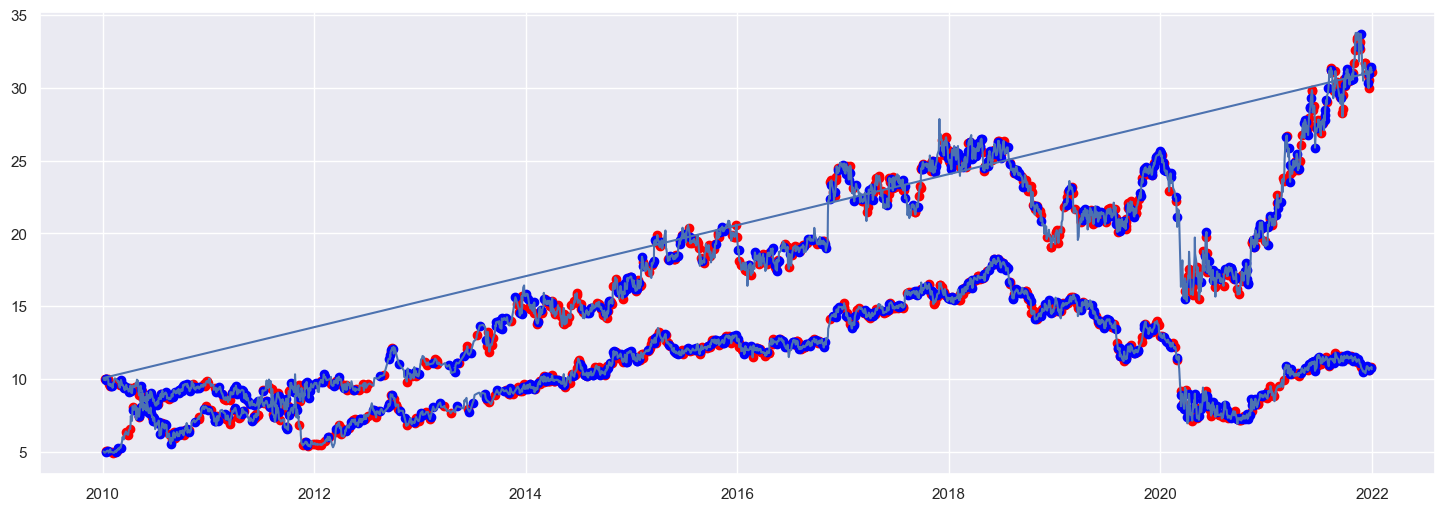

In [621]:
plt.plot(mini_dataset['date'], mini_dataset['price'])

red_dots_x = mini_dataset[mini_dataset['Buy'] == 1]['date']
red_dots_y = mini_dataset[mini_dataset['Buy'] == 1]['price']
plt.scatter(red_dots_x, red_dots_y, color='red')

blue_dots_x = mini_dataset[mini_dataset['Sell'] == 1]['date']
blue_dots_y = mini_dataset[mini_dataset['Sell'] == 1]['price']
plt.scatter(blue_dots_x, blue_dots_y, color='blue')

plt.show()

In [622]:
# Action mapping
buy_sell_mapping = {x: x if x != 2 else -1 for x in [0,1,2]}
buy_sell_mapping

{0: 0, 1: 1, 2: -1}

## Naive Environment

In [623]:
mini_dataset['date'] = pd.to_datetime(mini_dataset['date'])
mini_dataset = mini_dataset.sort_values(["date", "permno"], ignore_index=True)
mini_dataset.index = mini_dataset["date"]

mini_dataset.index = mini_dataset["date"].factorize()[0]

# mini_dataset.loc[8,'price'] = (5.05, 9.8)
# mini_dataset.loc[8]

mini_dataset.loc[8:11]

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,moribvol,moribvol_pctl,autocorr,buyminusselltrades,buyminusselltrades_abs,buyminussellvol,buyminussellvol_abs,effectivespread_percent_dw,hindex,overnightproduct,percentpriceimpact_lr_dw,percentrealizedspread_lr_dw,priceimpactintraday,quotedspread_percent_tw,realizedvol,realizedvolintraday,askhi,baspread,bidlo,hlspread,ivol_q,ivol_t,me,n30_pos,n5_pos,prc,ret,ret_abs,ret_am,ret_cto,ret_cto_abs,ret_otc,ret_otc_abs,ret_pm,total_n_trades_a,total_n_trades_m,turnover,turnover_am,var_ratio1,var_ratio2,turnover_pm,buyminussellvwap,priceimpactovernight,tsignsqrtdvol1,tsignsqrtdvol2,Buy,Sell,ind
8,89425,WTBA,WEST BANCORPORATION INC,2010-01-15,4.000,XLF,5.070,88.238,1.000,98,-0.786,0.005,-0.452,0.697,0.027,0.265,0.641,0.100,0.917,-0.262,-0.184,-0.318,-0.754,-0.747,-0.603,-0.433,-0.586,-0.869,-0.181,-0.218,-0.319,0.268,-0.702,-0.595,0.040,-0.753,-0.253,0.077,-0.608,-0.159,-0.632,0.061,-0.325,-0.420,-0.549,-0.573,0.647,0.828,-0.740,-0.132,-0.160,0.242,0.240,1.000,0.000,1.000
8,90718,BFIN,BANKFINACIAL CORP,2010-01-15,4.000,XLF,10.000,214.160,-0.619,12,-1.341,-0.033,-0.414,0.469,-0.215,0.007,0.120,0.088,0.004,-0.007,-0.190,-0.329,-0.795,-0.781,-0.292,-0.407,-0.274,-0.760,-0.183,-0.214,-0.297,0.547,0.090,-0.280,-0.041,-0.855,-0.011,-0.041,-0.746,-0.010,-0.794,-0.001,-0.325,-0.410,-0.504,-0.560,1.243,0.473,-0.702,0.059,-0.170,-0.159,-0.209,0.000,0.000,0.000
9,89425,WTBA,WEST BANCORPORATION INC,2010-01-19,4.000,XLF,5.090,88.586,0.000,52,-2.256,0.048,-0.440,0.157,-0.547,-0.097,0.650,0.054,0.243,-0.253,-0.166,-0.294,-0.820,-0.825,-0.603,-0.383,-0.584,-0.975,-0.181,-0.214,-0.319,-0.847,-1.425,-0.594,0.039,-0.753,-0.041,0.077,-0.608,0.076,-0.689,0.134,-0.304,-0.429,-0.695,-0.656,0.695,0.762,-0.776,-0.200,-0.139,0.101,0.622,0.000,0.000,0.000
9,90718,BFIN,BANKFINACIAL CORP,2010-01-19,4.000,XLF,10.010,214.374,1.000,98,-0.592,0.128,-0.361,1.039,0.392,-0.399,-0.200,0.091,-0.270,-0.274,-0.187,-0.317,-0.738,-0.718,-0.291,-0.459,-0.273,-0.760,-0.184,-0.218,-0.297,0.268,-0.323,-0.280,-0.020,-0.829,-0.144,-0.070,-0.712,0.022,-0.755,0.025,-0.325,-0.411,-0.478,-0.483,1.514,0.386,-0.481,-0.059,-0.162,-0.279,-0.288,1.000,0.000,1.000
10,89425,WTBA,WEST BANCORPORATION INC,2010-01-20,4.000,XLF,5.080,88.412,-1.000,3,0.036,-0.007,-0.440,0.099,-0.609,0.126,-0.274,0.110,0.811,-0.346,-0.167,-0.276,-0.714,-0.700,-0.600,-0.383,-0.586,-0.696,-0.183,-0.212,-0.319,0.268,-0.840,-0.594,-0.081,-0.804,-0.312,0.077,-0.609,-0.158,-0.633,0.207,-0.304,-0.423,-0.606,-0.597,0.464,0.486,-0.710,-0.159,0.011,-0.675,-0.764,0.000,1.000,-1.000
10,90718,BFIN,BANKFINACIAL CORP,2010-01-20,4.000,XLF,9.980,213.732,0.462,86,0.301,-0.061,-0.387,-0.269,-0.304,-0.386,-0.515,0.088,-0.274,-0.258,-0.190,-0.322,-0.738,-0.718,-0.294,-0.407,-0.274,-0.830,-0.179,-0.217,-0.298,0.547,0.159,-0.282,-0.102,-0.777,-0.441,-0.041,-0.746,-0.064,-0.747,0.440,-0.304,-0.407,-0.548,-0.541,1.047,0.935,-0.610,-0.204,-0.170,-0.186,-0.241,0.000,0.000,0.000
11,89425,WTBA,WEST BANCORPORATION INC,2010-01-21,4.000,XLF,4.950,86.150,0.600,93,1.685,-0.079,-0.369,-0.109,-0.475,-0.394,-0.129,0.066,-0.320,-0.240,-0.169,-0.285,-0.706,-0.691,-0.603,-0.432,-0.592,-0.576,-0.180,-0.218,-0.320,-0.289,-0.874,-0.603,-0.561,-0.196,-0.825,0.077,-0.609,-0.719,0.051,-0.198,-0.242,-0.416,-0.556,-0.501,0.692,1.430,-0.649,-0.259,0.012,-0.249,-0.097,0.000,0.000,0.000
11,90718,BFIN,BANKFINACIAL CORP,2010-01-21,4.000,XLF,9.610,205.808,-0.086,45,1.138,-0.005,-0.442,-0.184,-0.395,-0.386,-0.286,0.088,-0.272,-0.259,-0.181,-0.305,-0.601,-0.564,-0.296,-0.404,-0.290,-0.412,-0.185,-0.218,-0.299,0.547,-0.117,-0.305,-0.794,0.099,-0.842,-0.043,-0.744,-0.924,0.302,-0.280,-0.304,-0.410,-0.546,-0.557,0.780,0.243,-0.659,0.024,-0.168,-0.054,-0.065,0.000,0.000,0.000


In [656]:
K = 2
state_dim = 1 + 3 * K + len(features) * K
action_dim = 2
stock_dim = K
max_action = 1

env_config = {
    "price_array": mini_dataset['price'].loc[8:11].values.reshape(-1, K),
    "tech_array": mini_dataset[features].loc[8:11].values.reshape(-1, K * len(features)),
    "label_array": mini_dataset['Buy'].loc[8:11].values.reshape(-1, K),
    "if_train": False,
    "reward_scaling":1e-1, 
}

env = StockTradingEnv(config=env_config)

In [657]:
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment

def eval_policy(policy, env, seed, eval_episodes=10):
    eval_env = env
    eval_env.seed(seed + 100)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))     
            state, reward, done, _ = env.step(np.asarray([buy_sell_mapping[x] for x in action.flatten()]))
                
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

## Some Environment

In [606]:
merged_dataset['date'] = pd.to_datetime(merged_dataset['date'])
merged_dataset = merged_dataset.sort_values(["date", "permno"], ascending=[False, True], ignore_index=True)

# mini_dataset.index = mini_dataset["date"]
# mini_dataset.index = mini_dataset["date"].factorize()[0]


In [607]:
# Num of listed and recored ticker data in the final year
merged_dataset.groupby(["date"])['permno'].count()[-252:]

date
2020-12-31    3378
2021-01-04    3420
2021-01-05    3430
2021-01-06    3441
2021-01-07    3416
              ... 
2021-12-27    3596
2021-12-28    3635
2021-12-29    3530
2021-12-30    3490
2021-12-31    3504
Name: permno, Length: 252, dtype: int64

In [608]:
def get_ever_lasting_ticker(df, N=63):
    # Get the minimum and maximum dates in the DataFrame
    sorted_dates = df['date'].unique()
    sorted_dates = np.sort(sorted_dates)[::-1] # sort in descending order
    sorted_dates = sorted_dates[:N]
    
    min_date = sorted_dates.min()
    max_date = sorted_dates.max()
    
    subset_df = df[(df['date'] >= min_date) & (df['date'] <= max_date)]
    subset_tic = set(df[df['date'] == max_date]['permno'].unique()) # starting set

    # Iterate through each date to find common tickers in the DataFrame
    for date in sorted_dates:
        current_date_tic = set(df[df['date'] == date]['permno'].unique())
        subset_tic = subset_tic.intersection(current_date_tic)
    return subset_tic


tic_lst = list(get_ever_lasting_ticker(merged_dataset, N=64))[:30] # random pick first 30 tickers 
len(tic_lst)

30

In [609]:
ever_lasting_dataset = merged_dataset[merged_dataset['permno'].isin(tic_lst)]
ever_lasting_dataset['Buy'].sum()
ever_lasting_dataset['Sell'].sum()

917.0

649.0

# Model - DDPG

In [668]:
from OurDDPG import DDPG

seed = 43
start_timesteps = 40
eval_freq = 50
max_timesteps = 500
expl_noise = 0.5
batch_size = 256
discount = 0.99
tau = 0.005

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "hidden_dim": 64,
    "stock_dim": K,
    "discount": discount,
    "tau": tau,
}

# Initialize policy
policy = DDPG(**kwargs)

In [669]:
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder

replay_buffer = utils.ReplayBuffer(state_dim, action_dim, K, max_size=start_timesteps) # dim = 1 for class index 

# Evaluate untrained policy
evaluations = [eval_policy(policy, env, seed)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

for t in range(int(max_timesteps)):
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < start_timesteps:
        action = np.random.dirichlet(np.ones(action_dim), size=stock_dim)

#         # Fit and transform the labels array to one-hot encoded format  
#         action = F.one_hot(torch.FloatTensor(env.label_ary[env.day]).to(torch.int64), 
#                            num_classes=action_dim).numpy()        
    else:
        action = (
            policy.actor(torch.FloatTensor(state)).detach().numpy() 
            + np.random.normal(0, expl_noise, size=(stock_dim,action_dim))
        ).clip(0, 1)
        action = softmax(action, -1)
        
#     if t % 20 == 0:
#         env.epsilon = min(1, (t/ max_timesteps))

    # Perform action
    next_state, reward, done, _ = env.step(np.asarray([buy_sell_mapping[x] for x in action.argmax(-1).flatten()]))
    done_bool = float(done)

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        policy.train(replay_buffer, batch_size)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward*10:.3f}")
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        evaluations.append(eval_policy(policy,env, seed))
        state, done = env.reset(), False

---------------------------------------
Evaluation over 10 episodes: -0.000
---------------------------------------
Total T: 3 Episode Num: 1 Episode T: 3 Reward: -0.003
Total T: 6 Episode Num: 2 Episode T: 3 Reward: -0.001
Total T: 9 Episode Num: 3 Episode T: 3 Reward: -0.003
Total T: 12 Episode Num: 4 Episode T: 3 Reward: -0.002
Total T: 15 Episode Num: 5 Episode T: 3 Reward: -0.001
Total T: 18 Episode Num: 6 Episode T: 3 Reward: -0.003
Total T: 21 Episode Num: 7 Episode T: 3 Reward: 0.001
Total T: 24 Episode Num: 8 Episode T: 3 Reward: -0.006
Total T: 27 Episode Num: 9 Episode T: 3 Reward: -0.005
Total T: 30 Episode Num: 10 Episode T: 3 Reward: -0.006
Total T: 33 Episode Num: 11 Episode T: 3 Reward: -0.005
Total T: 36 Episode Num: 12 Episode T: 3 Reward: -0.001
Total T: 39 Episode Num: 13 Episode T: 3 Reward: -0.005
Total T: 42 Episode Num: 14 Episode T: 3 Reward: -0.006
Total T: 45 Episode Num: 15 Episode T: 3 Reward: 0.001
Total T: 48 Episode Num: 16 Episode T: 3 Reward: 0.000
---

Total T: 403 Episode Num: 129 Episode T: 5 Reward: -0.001
Total T: 406 Episode Num: 130 Episode T: 3 Reward: 0.000
Total T: 409 Episode Num: 131 Episode T: 3 Reward: -0.005
Total T: 412 Episode Num: 132 Episode T: 3 Reward: 0.000
Total T: 415 Episode Num: 133 Episode T: 3 Reward: 0.000
Total T: 418 Episode Num: 134 Episode T: 3 Reward: -0.003
Total T: 421 Episode Num: 135 Episode T: 3 Reward: 0.000
Total T: 424 Episode Num: 136 Episode T: 3 Reward: 0.000
Total T: 427 Episode Num: 137 Episode T: 3 Reward: 0.000
Total T: 430 Episode Num: 138 Episode T: 3 Reward: 0.000
Total T: 433 Episode Num: 139 Episode T: 3 Reward: 0.001
Total T: 436 Episode Num: 140 Episode T: 3 Reward: 0.000
Total T: 439 Episode Num: 141 Episode T: 3 Reward: 0.000
Total T: 442 Episode Num: 142 Episode T: 3 Reward: -0.002
Total T: 445 Episode Num: 143 Episode T: 3 Reward: 0.000
Total T: 448 Episode Num: 144 Episode T: 3 Reward: 0.000
---------------------------------------
Evaluation over 10 episodes: 0.000
---------

In [670]:
state, done = env.reset(), False
avg_reward = 0

while not done:
    state = (np.array(state).reshape(1,-1) - 0)/1
    action = policy.select_action(state)
    
    print(policy.actor(torch.FloatTensor(state)))
    print(np.asarray([buy_sell_mapping[x] for x in action]))
    
#     print(env.price_ary[env.day])
#     action = np.asarray([1,0])

    state, reward, done, _ = env.step(np.asarray([buy_sell_mapping[x] for x in action]))
    avg_reward += float(reward)
    
avg_reward*10


tensor([[[9.9984e-01, 1.5770e-04],
         [9.9993e-01, 7.4825e-05]]], grad_fn=<SoftmaxBackward0>)
[0 0]
tensor([[[9.9993e-01, 6.5218e-05],
         [9.9997e-01, 2.5800e-05]]], grad_fn=<SoftmaxBackward0>)
[0 0]
tensor([[[9.9989e-01, 1.1342e-04],
         [9.9996e-01, 4.4233e-05]]], grad_fn=<SoftmaxBackward0>)
[0 0]


0.0

In [671]:
env.episode_return
env.actions_memory
env.rewards_memory
env.total_asset

0.0

[array([0, 0]), array([0, 0]), array([0, 0])]

[0.0, 0.0, 0.0]

100.0

In [672]:
eval_policy(policy,env, seed)
env.episode_return
env.actions_memory
env.rewards_memory
env.total_asset

---------------------------------------
Evaluation over 10 episodes: 0.000
---------------------------------------


0.0

0.0

[array([0, 0]), array([0, 0]), array([0, 0])]

[0.0, 0.0, 0.0]

100.0